# Minibackend example
This notebook aims to illustrate how `openeo-pg-parser-networkx` can be used together with `openeo-processes-dask` to execute an OpenEO process graph locally.
Note: This capability has also been called the "mini-backend" (see [GH issue with discussion](https://github.com/Open-EO/PSC/issues/16)).

We'll demonstrate this capability through the following steps:
- Load a process graph that represents a computation to be executed on an OpenEO backend and parse it to a traversible Python object using `openeo-pg-parser-networkx`
- Traverse the process graph and maps the nodes to a nested Python function
- Execute that function

Let's go!

## Process graph creation
We'll keep it super simple and use a process graph that: 
1) loads a small part of the boa_sentinel_2 collection
2) computes Enhanced Vegetation Index (EVI) for each pixel
3) multiplies each pixel with a scalar 
4) saves the result as a NetCDF

Specifically, the OpenEO processes necessary to encode this computation are:
1) `load_collection`
2) `reduce_dimension`
    - subprocess: `evi`-processgraph
3) `reduce_dimension`
    - subprocess: `min`
4) `save_result`

In [1]:
from openeo_pg_parser_networkx import OpenEOProcessGraph

EVI_GRAPH_PATH = "./data/pg-evi-example.json"

parsed_graph = OpenEOProcessGraph.from_file(EVI_GRAPH_PATH)

Deserialised process graph into nested structure


Walking node root-e298ce00-9131-48e3-94a2-559580f96fe9
Walking node mintime-e298ce00-9131-48e3-94a2-559580f96fe9
Walking node min-b130a201-85a8-4792-be65-688af048cbf1
Walking node evi-e298ce00-9131-48e3-94a2-559580f96fe9
Walking node m3-06d7a847-5e5b-43e3-b162-96523efef2c1
Walking node div-06d7a847-5e5b-43e3-b162-96523efef2c1
Walking node sub-06d7a847-5e5b-43e3-b162-96523efef2c1
Walking node nir-06d7a847-5e5b-43e3-b162-96523efef2c1
Walking node red-06d7a847-5e5b-43e3-b162-96523efef2c1
Walking node add_one-06d7a847-5e5b-43e3-b162-96523efef2c1
Walking node sum-06d7a847-5e5b-43e3-b162-96523efef2c1
Walking node nir-06d7a847-5e5b-43e3-b162-96523efef2c1
Walking node m1-06d7a847-5e5b-43e3-b162-96523efef2c1
Walking node red-06d7a847-5e5b-43e3-b162-96523efef2c1
Walking node m2-06d7a847-5e5b-43e3-b162-96523efef2c1
Walking node blue-06d7a847-5e5b-43e3-b162-96523efef2c1
Walking node load_collection-e298ce00-9131-48e3-94a2-559580f96fe9


In [2]:
parsed_graph

We can see that `OpenEOProcessGraph` has parsed the process graph - let's plot it!


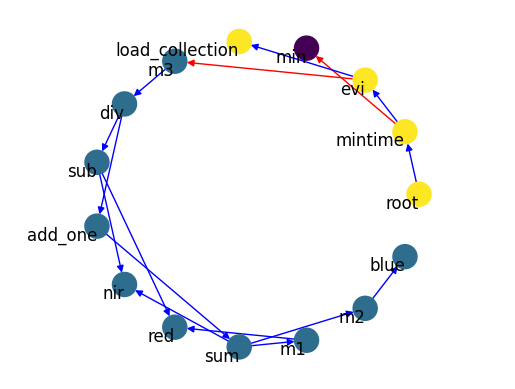

In [3]:
parsed_graph.plot()

The blue edges signify a `ResultReference` edge, where the result of the upstream process needs to be passed down to the downstream process as a parameter. 
E.g. in this process graph the results of `load_collection1` need to be passed on to `evi`. 
The red edges indicate `Callback` edges. These occur when a "parent" process calls upon a "child" process, i.e. to apply a reducer over specific dimension of a datacube. 
In this case the parent process is `reduce_dimension`, which applies the a sub-processgraph to calculate evi for all the pixels.  

## Execute the process graph

To execute a process graph, `OpenEOProcessGraph` needs to know which Python code to call for each of the nodes in the graph. This information is provided by a "process registry", which is basically a dictionary that maps `process_id` to their actual Python implementations as `Callable`s.

 When provided with a ProcessRegistry object (as defined in [openeo-processes-dask](https://github.com/Open-EO/openeo-processes-dask/blob/main/openeo_processes_dask/core.py)), `OpenEOProcessGraph` can translate the process graph into Python code using the `to_callable()` method.

In [4]:
%pip install "openeo_processes_dask[implementations]"
%pip install "netCDF4"


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
import importlib
import inspect

from openeo_pg_parser_networkx import ProcessRegistry
from openeo_processes_dask.process_implementations.core import process
from openeo_pg_parser_networkx.process_registry import Process

process_registry = ProcessRegistry(wrap_funcs=[process])

# Import these pre-defined processes from openeo_processes_dask and register them into registry
processes_from_module = [
    func
    for _, func in inspect.getmembers(
        importlib.import_module("openeo_processes_dask.process_implementations"),
        inspect.isfunction,
    )
]

specs_module = importlib.import_module("openeo_processes_dask.specs")
specs = {
    func.__name__: getattr(specs_module, func.__name__)
    for func in processes_from_module
}

for func in processes_from_module:
    process_registry[func.__name__] = Process(
        spec=specs[func.__name__], implementation=func
    )

# I/O processes aren't generic (yet), therefore have to custom define those. 
def load_collection(id, spatial_extent, temporal_extent, bands = [], properties = {}, **kwargs):
    # No generic implementation available, so need to implement locally!
    import xarray as xr
    return xr.open_dataset("./data/boa.nc").to_array(dim="bands")

def save_result(data, format = 'netcdf', options = None):
    # No generic implementation available, so need to implement locally!
    pass

from openeo_processes_dask.specs import load_collection as load_collection_spec
from openeo_processes_dask.specs import save_result as save_result_spec

process_registry["load_collection"] = Process(spec=load_collection_spec, implementation=load_collection)
process_registry["save_result"] = Process(spec=save_result_spec, implementation=save_result)



ImportError: attempted relative import with no known parent package

In [11]:
pg_callable = parsed_graph.to_callable(process_registry=process_registry)

In [14]:
pg_callable()